<a href="https://colab.research.google.com/github/seidikun/nivelamento-ml/blob/main/Nivelamento_ML_Aula_4_Intro_a_Regress%C3%A3o_Log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nicelamento ML Aula 4: Introdução a Regressão Logística

Na aula passada, vimos como gerar uma reta ou plano de tendência dos dados. A ideia da regressão linear é encontrar de forma automática a reta/plano que gera o menor erro em relação aos dados. 

Nesta aula, vamos ver um novo tipo de regressão: a regressão logística, que é usada para predizer a probabilidade de um evento. Qual a utilidade disso na prática?

No IIN-ELS temos exemplos muito claros:

*   Um classificador de pensamento motor (imagética das pernas, por exemplo) vs baseline a partir de sinal EEG
*   Detecção automática de comportamento de camundongos por meio da filmagem deles
*   Detecção do início de uma crise epiléptica a partir de dados LFP

A regressão logística se extende a outros domínios, por exemplo classificação de imagens tomográficas para diagnóstico de tumor, detecção de objetos por carros autônomos, predição de clima, etc.

Com regressão linear e regressão logística, você terá a base para já iniciar algum projeto em machine learning.


Antes de iniciar, vamos revisar regressão linear




## Importar as bibliotecas necessárias

In [1]:
# Bibliotecas que já conhecemos
import pandas as pd             # Trabalho com dados tabulares
import matplotlib.pyplot as plt # Visualização de figuras e manipulação do tamanho e disposição delas
import seaborn as sns           # API sobre o matplotlib, que facilita a criação e customização das figuras
import numpy as np              # Operações numéricas entre vetores, matrizes, etc

# Biblioteca nova, para a geração de modelos de predição
from sklearn.preprocessing   import RobustScaler        # para auxiliar a regressão logística
from sklearn.model_selection import train_test_split    # separação entre base de treino e de teste
from sklearn.linear_model    import LinearRegression    # modelo que vamos usar
from sklearn.linear_model    import LogisticRegression  # segundo modelo que usaremos

In [ ]:
#@title 

# @markdown Execute essa célula para criar a função de plotagem

def plot_observed_vs_predicted(x, y, y_hat, coef):
  """ Plot observed vs predicted data

  Args:
    x (ndarray): observed x values
    y (ndarray): observed y values
    y_hat (ndarray): predicted y values
    coef (ndarray):
  """
  fig, ax = plt.subplots()
  ax.scatter(x, y, label='Dado Real')  # our data scatter plot
  ax.plot(x, y_hat, color='r', label='Predição')  # our estimated model
  # plot residuals
  ymin = np.minimum(y, y_hat)
  ymax = np.maximum(y, y_hat)
  ax.vlines(x, ymin, ymax, 'g', alpha=0.5, label='Resíduos')
  ax.set(
      title=fr"$coeficiente$ = {coef:0.2f}, RMSE = {np.sqrt(np.mean((y - y_hat)**2)):.2f}",
      xlabel='x',
      ylabel='y'
  )
  ax.legend()

## Revisão - Regressão Linear

Vamos gerar nossos dados de monitoramento do preço da passagem para o Rio

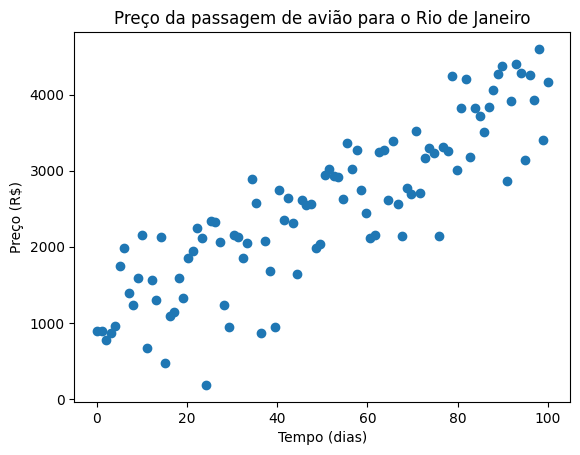

In [ ]:
# @title

# @markdown Execute essa célula para gerar dados

# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)

# Let's set some parameters
theta = 30
n_samples = 100

# Draw x and then calculate y
x = np.linspace(0, n_samples, n_samples)  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)*500  # sample from a standard normal distribution
y = theta * x + noise + 1000

# Plot the results
fig, ax = plt.subplots()
plt.title('Preço da passagem de avião para o Rio de Janeiro')
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='Tempo (dias)', ylabel='Preço (R$)');

Na aula passada, você tentou fazer a regressão 'na mão', reduzindo o erro entre a reta e os dados

**[Exercício] Teste encontrar novamente a melhor reta que explica a tendência desses dados. Explique seu racioncínio. O que você usou para dizer que o resultado encontrado é o melhor possível?**


interactive(children=(FloatSlider(value=20.0, description='a', max=50.0), FloatSlider(value=0.0, description='…

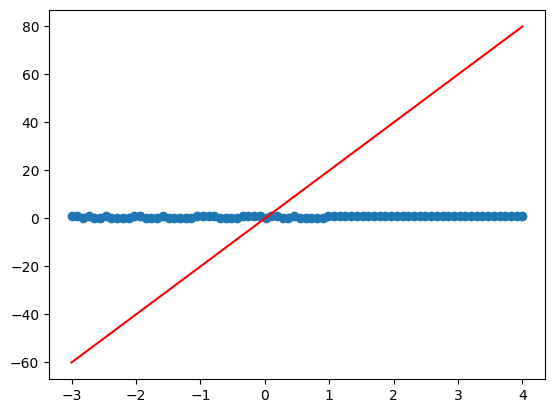

In [ ]:
#@title

#@markdown Execute a célula para iniciar a simulação
import ipywidgets as widgets       # interactive display

@widgets.interact(a=widgets.FloatSlider(20, min=0.0, max=50),
                  b=widgets.FloatSlider(0, min=-2000, max=2000))
def plot_data_estimate(a, b):
  y_hat = a * x + b
  plot_observed_vs_predicted(x, y, y_hat, a)
  plt.show()

  print('Equação do preço:\nPREÇO = ', a, '*x + ', b)

Agora vamos fazer isso com um modelo de regressão linear

Coeficiente angular:  0.12050264550264547
Intercepção:          0.6022486772486773
Erro quadrado médio:  0.16
R²:                   0.27


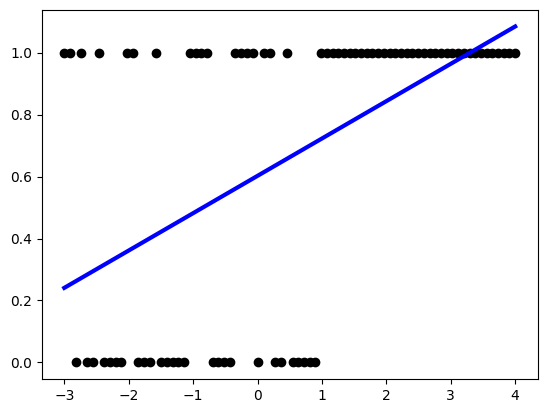

In [ ]:
# Importando métricas
from sklearn.metrics import mean_squared_error, r2_score

# Mudando o tamanho do eixo x para ter uma dimensão a mais (requisito para o modelo rodar)
x = x.reshape(-1, 1)

# Instanciando o modelo de regressão linear do sklearn
regr = LinearRegression()

# Treino do modelo, a partir dos dados
regr.fit(x, y)

# Predições sobre os dados 
y_pred = regr.predict(x)

# Coeficientes
print("Coeficiente angular: ", regr.coef_[0])
print("Intercepção:         ", regr.intercept_)

# Erro quadrado médio - métrica de validação
print("Erro quadrado médio:  %.2f" % mean_squared_error(y, y_pred))
# Coeficiente de determinação - medida de quanto a reta explica os dados (0 = nada, 1 = perfeito)
print("R²:                   %.2f" % r2_score(y, y_pred))

# Plotando
plt.scatter(x, y, color="black")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.show()

**[Exercício] Vamos analisar com calma:**

a. Qual a equação dessa reta? Ela é próxima da equação que você encontrou na mão?

b. Essa reta explica bem os dados? 

c. Observe que não separamos os dados em treino e teste. Porque isso seria importante?

Tudo certo? Pois vamos lá

## Regressão Logística [Troca de apresentador/a]

Imagine que você quer classificar se alguém pode ser considerado saudável ou não a partir de parâmetros como IMC, se fez cirurgia recentemente, se faz uso de medicamento, se bebe ou fuma, etc. No final da análise sua resposta (seu valor de y) ainda será: saudável (vamos considerar como 1 ou então o True) ou não saudável (0 ou False).

A regressão linear até pode ser usada, com você estabelecendo, por exemplo, que se o resultado da conta maluca seja y>=100 então a pessoa é saudável (True), caso contrário é False. Não parece ser mais complicado isso? E se tivesse uma função que já fornecesse um valor entre 0 e 1 e você só tenha que considerar se ele é alto o suficiente para ser True?

Como podem imaginar pelo título da aula, esta função é a regressão logística, sendo esta uma das funçãos mais usadas em modelos classificatórios. Vamos então entender um pouco mais como ela funciona.

## Intuição sobre regressão logística

Os dados abaixo possuem apenas dois valores de y: 0 ou 1. Queremos que dado o valor de x, a gente seja capaz de encontrar y. Vamos tentar fazer isso primeiro com uma regressão linear

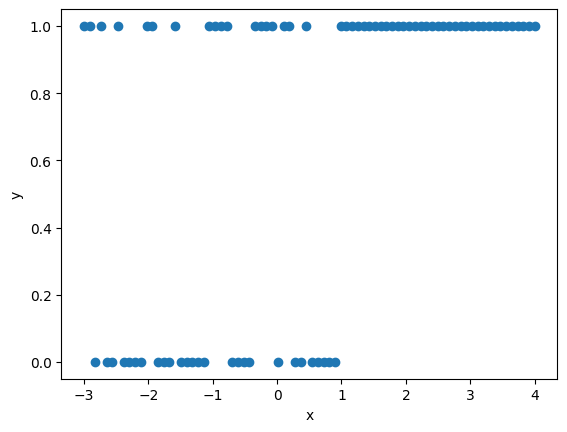

In [ ]:
# @title

# @markdown Execute essa célula para gerar dados

# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(8)

# Let's set some parameters
n_samples = 40

# Draw x and then calculate y
 # sample from a uniform distribution over [0,10)
zeros = np.random.randint(low=np.round(4*n_samples/5,0), high=np.round(8*n_samples/5,0), size=1)
zeros = np.random.randint(low=0, high=int(2*n_samples-zeros), size=zeros)
y = np.ones(2*n_samples)
y[zeros] = 0

x = np.linspace(-3,4,2*n_samples)

# Plot the results
fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

Coeficiente angular:  0.12050264550264547
Intercepção:          0.6022486772486773
Erro quadrado médio:  0.16
R²:                   0.27


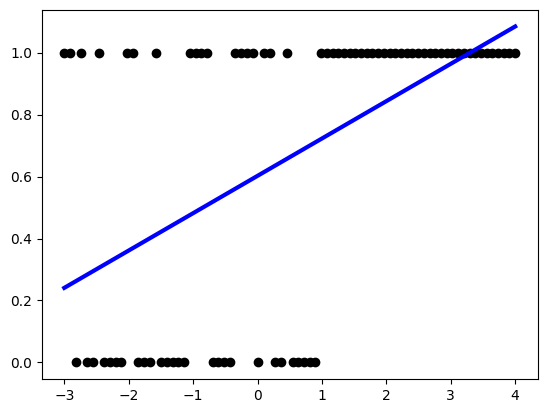

In [ ]:
# @title
# @markdown Execute essa célula para realizar a regressão logística (o código você já conhece)


# Mudando o tmanho do eixo x para ter uma dimensão a mais (requisito para o modelo rodar)
x = x.reshape(-1, 1)

# Instanciando o modelo de regressão linear do sklearn
regr = LinearRegression()

# Treino do modelo, a partir dos dados
regr.fit(x, y)

# Predições sobre os dados 
y_pred = regr.predict(x)

# Coeficientes
print("Coeficiente angular: ", regr.coef_[0])
print("Intercepção:         ", regr.intercept_)

# Erro quadrado médio - métrica de validação
print("Erro quadrado médio:  %.2f" % mean_squared_error(y, y_pred))
# Coeficiente de determinação - medida de quanto a reta explica os dados (0 = nada, 1 = perfeito)
print("R²:                   %.2f" % r2_score(y, y_pred))



# Plotando
plt.scatter(x, y, color="black")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.show()

**[Exercício] Discuta: a reta descreve bem os dados? Porque?**

Como decidir a partir dessa reta quais valores são 0 e quais são 1?

Vamos tentar a seguinte abordagem: um limiar em y vai separar os dados. Valores acima do limiar são considerados 1 e valores abaixo são considerados 0

In [ ]:
# @title

# @markdown Execute essa célula para alterar o limiar de classificação
@widgets.interact(a=widgets.FloatSlider(0.5, min=-2, max=2))

def plot_log_reg(a):
  # Plotando
  plt.scatter(x, y, color="black")
  plt.plot(x, y_pred, color="blue", linewidth=3)
  ind = np.argmin(np.abs(y_pred - a))
  plt.fill_between(x.flatten(), a, 1, where = x.flatten() > x.flatten()[ind], facecolor='red', alpha=0.5)
  plt.fill_between(x.flatten(), 0, a, where = x.flatten() < x.flatten()[ind], facecolor='blue', alpha=0.5)
  plt.show()

interactive(children=(FloatSlider(value=0.5, description='a', max=2.0, min=-2.0), Output()), _dom_classes=('wi…

**[Exercício] Isso funciona? Que critério você usou para encontrar o melhor limiar?**

O problema é que os dados não são lineares, e o nosso objetivo é classificar os dados. A reta possui valores infinitos para a direita e para a esquerda, então o limiar também pode ter qualquer valor entre menos infinito e mais infinito! Em Aprendizado de Máquina, uma solução possível é a regressão logística.

A função logística satura em 0 para valores muito negativos de x e satura em 1 para valores muito positivos de x. Vamos olhar a equação dela:

\begin{equation}
y = \frac{1}{1+e^{-kx}}
\end{equation}





Ela pode assustar a primeira vista, mas o _k_ da equação é só o coeficiente de ajuste da curva, que por sinal...

**[Exercício] Altere o valor de coef e veja o comportamento da curva**

In [ ]:
#@title

#@markdown Execute a célula para iniciar a simulação
import ipywidgets as widgets       # interactive display

x_hat = np.linspace(-3,4,2*n_samples)

@widgets.interact(coef=widgets.FloatSlider(1, min=0, max=50))
def plot_data_estimate(coef):
  y_hat = 1/(1+np.exp(-coef*x))
  plt.scatter(x,y)
  plt.plot(x, y_hat, 'red')
  x_min,x_max,_,_ = plt.axis()
  plt.hlines(0.5,x_min,x_max,color='y',linestyle=':')
  plt.legend(['Dado Real','Predição','Distância','Limiar'])
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='coef', max=50.0), Output()), _dom_classes=('widget-i…

Saturamos os valores em y. Como interpretar a curva? Lembre-se que a regressão logística retorna uma distribuição de probabilidades

**[Exercício] Interprete a curva de regressão logística**

Além disso, pelo formato da curva, acaba sendo mais fácil aplicar o mesmo funcionamento de utilizar limiar para determinar se y=1 ou y=0, só que agora obtendo um resultado bem melhor que na regressão logística.

**[Exercício] Vamos transformar essa distribuição de probabilidades em uma classificação, usando um limiar. Acima do valor do limiar, classificamos como 1, e abaixo como 0. Teste o comportamento da classificação abaixo.**



In [ ]:
# @title

# @markdown Execute essa célula para alterar o limiar de classificação
@widgets.interact(limiar=widgets.FloatSlider(0.5, min=0, max=1),
                  coef=widgets.FloatSlider(1, min=0, max=10))

def plot_log_reg(limiar, coef):
  # Plotando
  
  y_hat = 1/(1+np.exp(-coef*x))
  plt.scatter(x, y, color="black")
  plt.plot(x, y_hat, color="blue", linewidth=3)
  ind_pos = np.argmin(np.abs(y_hat - limiar))
  plt.fill_between(x.flatten(), limiar, 1, where = x.flatten() > x.flatten()[ind_pos], facecolor='red', alpha=0.5)
  plt.fill_between(x.flatten(), 0, limiar, where = x.flatten() < x.flatten()[ind_pos], facecolor='blue', alpha=0.5)
  plt.show()

interactive(children=(FloatSlider(value=0.5, description='limiar', max=1.0), FloatSlider(value=1.0, descriptio…

**[Exercício] Agora discuta: o que acontece conforme você aumenta o coeficiente da função logística? Como isso afeta a classificação?**

Perceba o seguinte: fizemos primeiro uma regressão logística, e com a curva encontrada, um limiar foi encontrado para classificar os dados. Foram duas coisas!

A regressão logística descreve uma distribuição entre 0 e 1, o limiar gera a classificação. Tanto a curva como o limiar podem ser encontrados de forma automática: pra isso serve o Aprendizado de Máquina

## Importando os dados [Troca de apresentador/a]

Nesta parte, iremos estar utilizando o [Heart Attack Analysis & Prediction Dataset](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)

In [ ]:
# Baixa o dataset
!gdown '1TYkhOM1XvNW1-EpZd-li4dLbYnAfnWqd'

Downloading...
From: https://drive.google.com/uc?id=1TYkhOM1XvNW1-EpZd-li4dLbYnAfnWqd
To: /content/heart.csv
100% 11.3k/11.3k [00:00<00:00, 37.2MB/s]


In [ ]:
heart_attack = pd.read_csv('heart.csv')

heart_attack.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


De forma geral, esse dataset apresenta a coleta de dados demográficos e de saúde de pessoas que sofreram ataque cardíaco. Não fica claro na documentação, ma imagine que os participantes foram triados e em uma pesquisa posterior (talvez um mês após) foi verificado se a condição atual deles desencadeou um ataque cardíaco.

Temos então dados de idade (age), sexo (sex), fisiológicos (demais) e um rótulo output, indicando ataque cardíaco (output = 1) ou não (output = 0)

## Análise Exploratória de Dados

Novamente, antes de entrar na parte do modelo, é bom a gente mais sobre os dados com que estamos trabalhando. Então, bora fazer um EDA bem rápido.

**[Exercício] Algum dado está faltando? Se estiver faltando, o que veríamos na saída da função abaixo?**

In [ ]:
##---Data types---#
heart_attack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


**[Exercício] Olhando para a descrição do DataSet, você consegue estabelecer alguma conclusão? Qual a faixa etária média? Muitas pessoas do dataset sofreram ataque cardíaco?**


In [ ]:
#---Medidas estatísticas---#
heart_attack.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exng,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


**[Exercício] Crie uma figura de 1 linha e 3 colunas sendo que:**

* **Na primeira coluna tenha um barplot do desfecho pela pressão do sangue em repouso de cada resultado possível do ecg em repouso**
* **Na segunda coluna, um boxplot da dor no peito pelo colesterol, diferenciando os sexos**
* **Na terceira coluna, um histograma da idade dos pacientes (use bins=10)**

Consulta:

* [barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html)

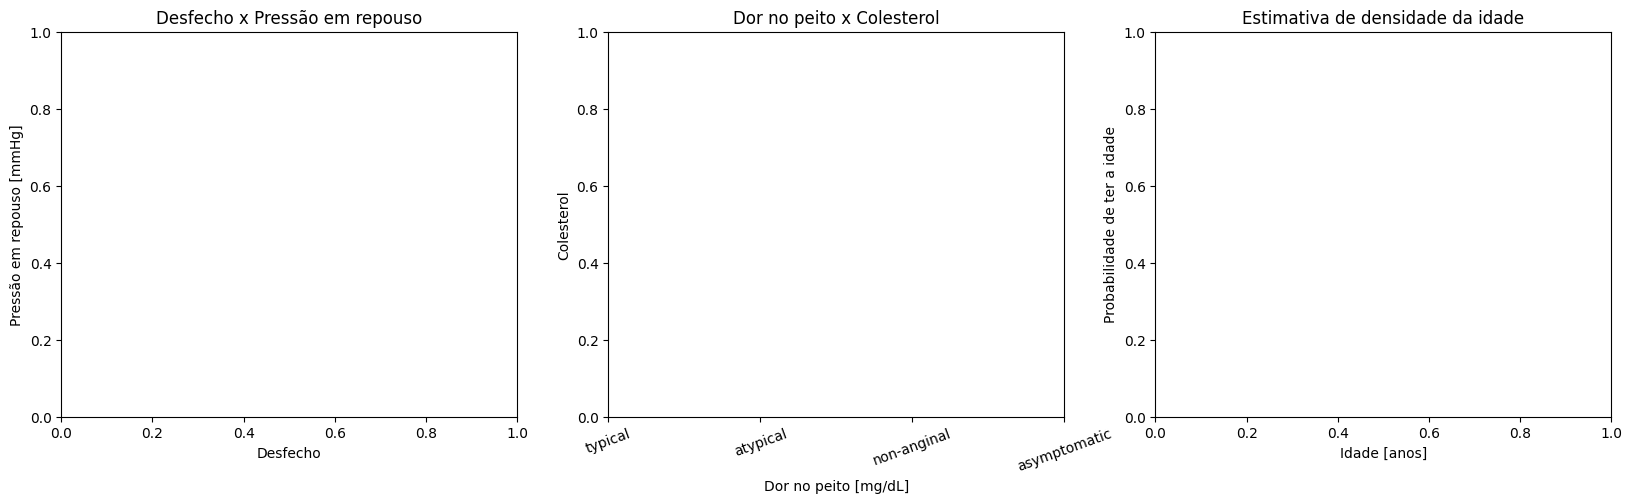

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title('Desfecho x Pressão em repouso')
plt.xlabel('Desfecho')
plt.ylabel('Pressão em repouso [mmHg]')

plt.subplot(1,3,2)
plt.title('Dor no peito x Colesterol')
plt.xlabel('Dor no peito [mg/dL]')
plt.ylabel('Colesterol')
plt.xticks(ticks=[0,1,2,3],labels=['typical','atypical','non-anginal','asymptomatic'],
           rotation=20)

plt.subplot(1,3,3)
plt.title('Estimativa de densidade da idade')
plt.xlabel('Idade [anos]')
plt.ylabel('Probabilidade de ter a idade')

plt.show()

### Dividir em treino e teste

Desta vez, já temos definida nossa coluna alvo

In [ ]:
# defining the features and target
X = heart_attack.drop(['output'],axis=1)
Y = heart_attack[['output']]

Alguma colunas possuem limites de valores muito distintos, o que pode causar uma variação de sensibilidade do modelo de acordo com a coluna (imagine uma coluna com valores entre 0 e 100000 e outra entre 0 e 0.5, mas o modelo treinado é um só). Uma solução é usar o RobustScale() do sklearn, que nada mais faz que normalizar os dados para que tenham média 0 e desvio-padrão 1.

In [ ]:
# Instanciando
scaler = RobustScaler()

# Aplicando o robust scaler
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]
X[con_cols] = scaler.fit_transform(X[con_cols])

Agora, com os dados preparados, finalmente podemos separar os dados em conjunto de treino e de teste. Lembrando que deixar 20% dos dados para o teste é algo arbitrário e podemos aumentar ou diminuir este valor de acordo com a quantidade de dados

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0,test_size=0.2)

### Treino do modelo

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

### Testar o modelo

Como na regressão logística a ideia é dar uma probabilidade, vulgo um resultado entre 0 e 1, utilizar o MSE (erro quadrático médio) e o R² pode não ser a melhor escolha.

Neste caso, por ser uma aplicação da área da saúde onde os casos positivos são bem importantes, é mais interessante calcular a sensibilidade (recall) da regressão.

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
y_train_predict = logreg.predict(X_train)
y_test_predict = logreg.predict(X_test)

print(f'Sensibilidade no treino: {np.round(recall_score(y_train, y_train_predict)*100,1)}%')
print(f'Sensibilidade no teste: {np.round(recall_score(y_test, y_test_predict)*100,1)}%')

Sensibilidade no treino: 89.3%
Sensibilidade no teste: 91.2%


**[Exercício] O que acontece com a sensibilidade se não padronizarmos os dados?**



#### Informação bônus

Outra métrica relevante nesta situação é o F1-Score, que teremos mais detalhes sobre na aula de métricas, mas para quem já quiser saber [sobre](https://en.wikipedia.org/wiki/F-score).

In [ ]:
from sklearn.metrics import f1_score

y_train_predict = logreg.predict(X_train)
y_test_predict = logreg.predict(X_test)

print(f'F1-Score no treino: {np.round(f1_score(y_train, y_train_predict),2)}')
print(f'F1-Score no teste: {np.round(f1_score(y_test, y_test_predict),2)}')

F1-Score no treino: 0.86
F1-Score no teste: 0.87
